# CRISM summary products - PlanetServer Python 2.7 API 

Developed for Python 2.7 - Anik Halder, Ramiro Marco Figuera

In [1]:
# Checking the version of Python

import sys
print(sys.version)

3.5.4 |Anaconda 4.2.0 (64-bit)| (default, Feb 19 2018, 10:59:04) 
[GCC 7.2.0]


In [2]:
import numpy as np

import re

import math

from astropy.io import fits

import urllib 

#import urllib2

#import requests

#import httplib

import xml.etree.ElementTree as ET

%matplotlib inline
import matplotlib.pyplot as plt

# reading the data from the bands_table.fits file

hdulist = fits.open("bands_table.fits")
tabledata = hdulist[1].data # assuming the first extension is a table

cols = hdulist[1].columns

band_name = tabledata["band_name"]
WV = tabledata["wavelength"]

%matplotlib notebook
#from ipywidgets import interact

## Formulation of function to find bandname and wavelength

In [3]:
def find_WV_bandname(name, nearest=True):
    # extract wavelength from formulation name e.g. R2950 --> 2950 nanometer --> 2.95 micrometer
    # nearest=True means that the nearest wavelength in the bands_table will be returned (default value)
    # nearest=False means that the exact wavelength as passed in 'name' shall be returned
    
    l = float(re.findall("\d+", name)[0])/1000 # converting into micrometer
    
    # nearest wavelength and the corresponding band name index of the given color
    idx = (np.abs(WV-l)).argmin()
    
    # return the corresponding values
    if (nearest==True):
        return WV[idx], band_name[idx]
    elif (nearest==False):
        return l, band_name[idx]


color = "R2260"

results = find_WV_bandname(color)

print ("Corresponding wavelength and bandname of", color ,": WV =", results[0],"; Band name", results[1])

Corresponding wavelength and bandname of R2260 : WV = 2.25827 ; Band name 192


## Formulation of family $f1$ - $BDXXXX$

### $$1-\left(\frac{R_c}{a* R_s+b* R_l}\right)$$

Associated Product # : 13, 19, 20, 21, 23, 27, 28, 29, 31, 33, 34, 36, 37, 39, 44, 46, 47, 48, 57
##### 19 summary products

In [4]:
# family f1 is of the formuation : 1-(Rc/(a*Rs+b*Rl)

def f1(lst = []):
    # lst has the arguments: Rc, Rs, Rl
    WV_Rc , bn_Rc = find_WV_bandname(lst[0]) # Rc
    WV_Rs , bn_Rs  = find_WV_bandname(lst[1]) # Rs
    WV_Rl , bn_Rl  = find_WV_bandname(lst[2]) # Rl

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[0], bn_Rc, lst[1], bn_Rs, lst[2], bn_Rl))    
        
    b = (WV_Rc - WV_Rs) / (WV_Rl - WV_Rs)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "(1 - (data.band_"+str(bn_Rc)+" / (("+str(a)+") * data.band_"+str(bn_Rs)+" + ("+str(b)+") * data.band_"+str(bn_Rl)+")))"
           
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
        
    return [FS, F]

#print f1(["R1320", "R1080", "R1750"])[1]


### Formulation of family $f1$ - $BDXXXX$ : $$1-\left(\frac{R_c}{a* R_s+b* R_l}\right)$$

In [5]:
# family f1 is of the formuation : 1-(Rc/(a*Rs+b*Rl)

def f1(lst = []):
    # lst has the arguments: Rc, Rs, Rl
    WV_Rc , bn_Rc = find_WV_bandname(lst[0]) # Rc
    WV_Rs , bn_Rs  = find_WV_bandname(lst[1]) # Rs
    WV_Rl , bn_Rl  = find_WV_bandname(lst[2]) # Rl

    b = (WV_Rc - WV_Rs) / (WV_Rl - WV_Rs)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "(1 - (data.band_"+str(bn_Rc)+" / (("+str(a)+") * data.band_"+str(bn_Rs)+ \
        " + ("+str(b)+") * data.band_"+str(bn_Rl)+")))"
           
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
        
    return [FS, F]

## Formulation of family  $f2$ - $min$

### $$min \left[\left(1-\frac{R_{1c}}{a* R_{1s}+b* R_{1l}}\right),\left( 1-\frac{R_{2c}}{a*R_{2s}+b*R_{2l}}\right)\right]$$

In [6]:
# family f2 is of the formuation : MIN [ 1-(R1c/(a*R1s+b*R1l) , 1-(R2c/(a*R2s+b*R2l) ]

def f2(lst = []):
    # lst has the arguments: Rc1, Rs1, Rl1 , Rc2, Rs2, Rl2
    
    FS1 = f1(lst[0:3])[0]
    FS2 = f1(lst[3:])[0]
    
    FS = "( "+FS1+" < "+FS2+" ) * "+FS1+" + ( "+FS1+" > "+FS2+" ) * "+FS2
    
    return [FS]
  
#print f2(["R2165", "R2120", "R2350", "R2210", "R2120", "R2350"])[0]

## Formulation of family $f3$ 

### $$0.5* \left(1-\frac{R_{1c}}{a* R_{1s}+b*R_{1l}}\right) + 0.5 *\left(1-\frac{R_{2c}}{a* R_{2s}+b* R_{2l}}\right)$$

Associated Product # : 24 - $BD1900_2$

##### 1 summary product

In [7]:
# family f3 is of the formuation : 0.5 * (1-(R1c/(a*R1s+b*R1l)) + 0.5*( 1-(R2c/(a*R2s+b*R2l))

def f3(lst = []):
    # lst has the arguments: R1c, R1s, R1l, R2c, R2s, R2l
    
    F1 = f1(lst[0:3])[1] # for components R1c, R1s, R1l
    F2 = f1(lst[3:])[1] # for components R2c, R2s, R2l
    
    # WCPS query as given by the computed product
    F = "(0.5 * ("+F1+")"+" + 0.5 * ("+F2+"))" 
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

#print f3(["R1930", "R1850", "R2067", "R1985", "R1850", "R2067"])[1]

## Formulation of family $f4$ - $RXXXX$

### $$R_1$$

Associated Product # : 12, 54, 55, 56, 60

##### 5 summary products

In [8]:
# family f4 is of the formuation : R1

def f4(lst = []):
    # lst has the arguments: R1
    
    WV_R1 , bn_R1 = find_WV_bandname(lst[0]) # R1
    
    # WCPS query as given by the computed product
    F = "(data.band_"+str(bn_R1)+")"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
        
    return [FS, F]

#print f4(["R1330"])[1]

## Formulation of family $f5$

### $$\frac{R_1}{R_2}$$

Associated Product # : 58 - $IRR2$ ; 59 - $IRR3$

##### 2 summary products

In [9]:
# family f5 is of the formuation : R1/R2

def f5(lst = []):
    # lst has the arguments: R1, R2
    
    WV_R1 , bn_R1 = find_WV_bandname(lst[0]) # R1
    WV_R2 , bn_R2 = find_WV_bandname(lst[1]) # R2
    
    # WCPS query as given by the computed product
    F = "(data.band_"+str(bn_R1)+" / data.band_"+str(bn_R2)+")"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

#print f5(["R2530", "R2210"])[1]

## Formulation of family $f6$

### $$1-\left(\frac{R_1}{R_2 * \frac{R_3}{R_4}}\right)$$

Associated Product # : 45 - $BD3000$

##### 1 summary product

In [10]:
# family f6 is of the formuation : 1-(R1/(R2*(R3/R4)))

def f6(lst = []):
    # lst has the arguments: R1, R2, R3, R4
    
    WV_R1 , bn_R1 = find_WV_bandname(lst[0]) # R1
    WV_R2 , bn_R2  = find_WV_bandname(lst[1]) # R2
    WV_R3 , bn_R3  = find_WV_bandname(lst[2]) # R3
    WV_R4 , bn_R4  = find_WV_bandname(lst[3]) # R4

    # WCPS query as given by the computed product
    F = "(1 - (data.band_"+str(bn_R1)+" / (data.band_"+str(bn_R2)+" * (data.band_"+str(bn_R3)+" / data.band_"+str(bn_R4)+"))))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

#print f6(["R3000", "R2530", "R2530", "R2210"])[1]

## Formulation of family $f7$

### $$1-\left(\frac{a*R_s+b*R_l}{R_c}\right)$$

Associated Product # : 40 - $SINDEX2$ ; 49 - $CINDEX2$

##### 2 summary products

In [11]:
# family f7 is of the formuation : 1-((a*Rs+b*Rl)/Rc)

def f7(lst = []):
    # lst has the arguments: Rs, Rl, Rc

    WV_Rs , bn_Rs  = find_WV_bandname(lst[0]) # Rs
    WV_Rl , bn_Rl  = find_WV_bandname(lst[1]) # Rl
    WV_Rc , bn_Rc = find_WV_bandname(lst[2]) # Rc

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[2], bn_Rc, lst[0], bn_Rs, lst[1], bn_Rl))    
        
    b = (WV_Rc - WV_Rs) / (WV_Rl - WV_Rs)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "(1 - ( (("+str(a)+") * data.band_"+str(bn_Rs)+" + ("+str(b)+") * data.band_"+str(bn_Rl)+") / data.band_"+str(bn_Rc)+"))"
        
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

#print f7(["R2120", "R2400", "R2290"])[1]

## Formulation of family $f8$ 

### $$1-\left(\frac{1-BD_1}{1-BD_2}\right)$$

Associated Product # : 22 - $ICER1_2$

##### 1 summary product

In [12]:
# family f8 is of the formuation : 1-((1-BD1)/(1-BD2)) i.e. composed of f1

def f8(lst = []):
    # lst has the arguments: dictionary, BD1, BD2
    
    dictionary = lst[0] 
    F1 = dictionary[lst[1]][0](dictionary[lst[1]][1])[1]
    F2 = dictionary[lst[2]][0](dictionary[lst[2]][1])[1]
    
    # WCPS query as given by the computed product
    F = "(1 - ((1 - "+F1+") / (1 - "+F2+")))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

# as dictionary hasn't been defined so far - e.g. for f8 can be seen after the definition of the dictionary

## Formulation of family $f9$ 

### $$\left( \frac{R_1-R_2}{W_2-W_1} \right)$$

#### Note: This family computes slope and intercept

Associated Product # : 18 - $ISLOPE1$

##### 1 summary product

In [13]:
# family f9 is of the formuation : ((R1-R2)/(W2-W1))

def f9(lst = []):
    # lst has the arguments: R1, R2
    
    WV_W1, bn_R1 = find_WV_bandname(lst[0], nearest=False) # W1 and R1
    WV_W2, bn_R2 = find_WV_bandname(lst[1], nearest=False) # W2 and R2
    
    # WCPS query as given by the computed product
    F = "((data.band_"+str(bn_R1)+" - data.band_"+str(bn_R2)+") / ("+str(WV_W2)+" - "+str(WV_W1)+"))"
    
    # calculating the slope and intercept for f12 which changes a bit: R2-R1/W2-W1
    slope = "((data.band_"+str(bn_R2)+" - data.band_"+str(bn_R1)+") / ("+str(WV_W2)+" - "+str(WV_W1)+"))"
    
    intercept = "(data.band_"+str(bn_R2)+" - "+slope+" * "+str(WV_W2)+")"    
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    return [FS, slope, intercept]    

#print f9(["R1815", "R2530"])[1]

## Formulation of function to find RC

In [14]:
def RC(lst = []):
    # lst has the arguments: RC, [R1, R2] with R1 and R2 the anchors
    
    WV_RC = find_WV_bandname(lst[0], nearest=False)[0]
    
    slope, intercept = f9(lst[1])[1:]
    
    F = "("+slope+" * "+str(WV_RC)+" + "+intercept+")"

    return F

#print RC(["RB2600",["R2456", "R2530"]])

## Formulation of family $f10$ 

### $$RBXXXX =\frac{RCXXXX - RXXXX }{RCXXXX}$$

Note: This family is the function that computes RB 

Associated Product # : 41 - $ICER2_2$

##### 1 summary product

In [15]:
# family f10 is of the formuation : RB1 = (RC1 - R1) / R1

def f10(lst = []):
    # lst has the arguments: RB, [R1, R2] where R1, R2 are the anchors
    
    # note that for finding bandname of a product, the initials do not matter i.e. whether it is RBXXXX,
    # RCXXXX or RXXXX - all have the same bandnames and here the parameter RB does not imply the function
    # but rather the bandname associated with it
        
    F_RC = RC(lst)
    F_R = f4(lst)[1] # Using formulation of family f4 : R1
    
    # WCPS query as given by the computed product
    F = "(("+F_RC+" - "+F_R+")/ "+F_RC+")"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

#print f10(["RB1210",["R1750","R2400"]])[1]

### $f10_{prima}$ is a different formulation of  $f10$ to include the absolute parameter in the product OLINDEX3

In [16]:
# family f10_prima is a special formulation of f10 to include the absolute parameter to compute OLINDEX3

# rest is the same as f10 : RB1 = (RC1 - R1) / R1

def f10_prima(lst = []):
    # lst has the arguments: RB, [R1, R2] where R1, R2 are the anchors
    
    # note that for finding bandname of a product, the initials do not matter i.e. whether it is RBXXXX,
    # RCXXXX or RXXXX - all have the same bandnames and here the parameter RB does not imply the function
    # but rather the bandname associated with it
        
    F_RC = RC(lst)
    F_R = f4(lst)[1] # Using formulation of family f4 : R1
    
    # WCPS query as given by the computed product !!!
    #F = "((("+F_RC+" - "+F_R+")/ (abs"+F_RC+"))"
    F = "(("+F_RC+" - "+F_R+")/ (abs"+F_RC+"))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]

#print f10(["RB1210",["R1750","R2400"]])[1]

## Formulation of family $f11$

### $$1-\left( \frac{\frac{R_a}{RC_a} +  \frac{R_b}{RC_b} +\frac{R_c}{RC_c}  + ...}{\frac{R_x}{RC_x} +  \frac{R_y}{RC_y} +\frac{R_z}{RC_z}  + ...}\right)$$

Associated Product # : 25 - $BD1900r2$ ; 32 - $D2200$ ; 38 - $D2300$

##### 3 summary products

In [17]:
# family f11 is of the formuation : 1- (Ra/a + Rb/RCb + Rc/RCc  + ... )/(Ra/a + Rb/RCb + Rc/RCc  + ... )

def f11(lst = []):
    # lst has the arguments: [Ra, Rb, Rc, ...], [Rx, Ry, Rz, ...], [R1, R2] where R1, R2 are the anchors for RC
    # and a,b,c... indicate the parameter under consideration in numerator
    # and x,y,z... indicate the parameter under consideration in denominator
    
    # computing the WCPS query as given by the computed product
    
    # numerator
    F_n = ""
    for i in range(len(lst[0])):
        F_R = f4([lst[0][i]])[1]
        F_RC = RC([lst[0][i],lst[-1]])
        
        if i == 0:
            F_n = F_n+F_R+" / "+F_RC
        else:
            F_n = F_n+" + "+F_R+" / "+F_RC
            
    # denominator
    F_d = ""
    for i in range(len(lst[0])):
        F_R = f4([lst[1][i]])[1]
        F_RC = RC([lst[1][i],lst[-1]])
        
        if i == 0:
            F_d = F_d+F_R+" / "+F_RC
        else:
            F_d = F_d+" + "+F_R+" / "+F_RC
            
    F = "(1-("+F_n+" / "+F_d+"))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]
    
#print f11([["R2210","RC2230"],["R2165","R2165"],["R1815","R2430"]])[1]

## Formulation of family $f12$ !!! Works only for first two parameters!!!

### $$RB_a*a + RB_b*b + RB_c*c  + ... $$

Associated Product # : 15 - $ LCPINDEX2$ ; 16 - $HCPINDEX2$

##### 3 summary products

In [18]:
# family f12 is of the formuation : RBa*a + RBb*b + RBc*c  + ... 

def f12(lst = []):
    # lst has the arguments: [RBa, a], [RBb,b], [RBc,c]..., [R1, R2] where R1, R2 are the anchors for RC
    # and a,b,c.. indicate the parameter under consideration
    
    # computing the WCPS query as given by the computed product
    F = ""
    for i in range(len(lst)-1):
        F_RB = f10([lst[i][0],lst[-1]])[1]
        if i == 0:
            F = F+F_RB+" * "+str(lst[i][1])
        else:
            F = F+" + "+F_RB+" * "+str(lst[i][1])
            
    F = "("+F+")"
    #print F
        
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]
    
#print f12([["RB2120",0.10], ["RB2140",0.10], ["RB2230",0.15], ["R1690","R2530"]])[1]

## Formulation of family $f13$ !!!Special one for OLINDEX3!!!

### $$RB_a*a + RB_b*b + RB_c*c  + ... $$

Associated Product # : 14 - $OLINDEX3$ 

##### 1 summary products

In [19]:
# family f13 is of the formuation : RBa*a + RBb*b + RBc*c  + ... 

def f13(lst = []):
    # lst has the arguments: [RBa, a], [RBb,b], [RBc,c]..., [R1, R2] where R1, R2 are the anchors for RC
    # and a,b,c.. indicate the parameter under consideration
    
    # computing the WCPS query as given by the computed product (using f10_prima)
    F = ""
    for i in range(len(lst)-1):
        F_RB = f10_prima([lst[i][0],lst[-1]])[1]
        if i == 0: # !!!
            #F = F+F_RB+" * "+str(lst[i][1]) +" )"
            F = F+F_RB+" * "+str(lst[i][1])
        else:
            #F = F+" + "+F_RB+" * "+str(lst[i][1])+" )"
            F = F+" + "+F_RB+" * "+str(lst[i][1])
            
    #F = F
    F = "("+F+")"
        
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))"
    
    return [FS, F]
    
#print f12([["RB2120",0.10], ["RB2140",0.10], ["RB2230",0.15], ["R1690","R2530"]])[1]

## Extracting bounding box information of coverage_id image from XML

In [20]:
def coordinates(coverage_id):

    coverageID = coverage_id.upper() # convert coverage_id to uppercase for XML file info on coverage
    xml_url = urllib.request.urlopen("http://access.planetserver.eu:8080/ps2/dataset?request=getCoverage&coverageID="+coverageID)
    xml_url_string = xml_url.read()

    #print xml_url_string
    
    tree = ET.fromstring(xml_url_string) # converting xml string into elements for parsing

    # storing the coverage_id's bounding coordinates i.e. maximum and minimum Latitudes and Longitudes 
    coords_degrees = {} 
    coords_metres = {} 
    centroid = {}
    
    r = 3396190.0
    
    for i in range(4):
        coords_degrees[tree[1][0][2][i].tag] = float(tree[1][0][2][i].text)
        if 'Lat' in tree[1][0][2][i].tag:
            coords_metres[tree[1][0][2][i].tag] = float(tree[1][0][2][i].text)*r*np.pi/180
        else:
            coords_metres[tree[1][0][2][i].tag] = float(tree[1][0][2][i].text)*r*np.pi/180
    #for j in range(1):
    #    centroid[tree[1][0][3][j].tag] = float([tree[1][0][3][j].text])
    centroid_long = float(tree[1][0][3][1].text)
            

    return coords_degrees, coords_metres, centroid_long
        
#coordinates("FRT00005A94_07_IF163L_TRR3")[2]
#print coordinates("FRT00005A94_07_IF163L_TRR3")[1]

In [21]:
summary_products = { "BD1300" : [f1, ["R1320", "R1080", "R1750"]], "BD1400" : [f1, ["R1395", "R1330", "R1467"]], 
                    "BD1435" : [f1, ["R1435", "R1370", "R1470"]], "BD1500_2" : [f1, ["R1525", "R1367", "R1808"]], 
                    "BD1750_2" : [f1, ["R1750", "R1690", "R1815"]], "BD2100_2" : [f1, ["R2132", "R1930", "R2250"]], 
                    "BD2165" : [f1, ["R2165", "R21!!!20", "R2230"]], "BD2190" : [f1, ["R2185", "R2120", "R2250"]],
                    "BD2210_2" : [f1, ["R2210", "R2165", "R2250"]], "BD2230" : [f1, ["R2235", "R2210", "R2252"]],
                    "BD2250" : [f1, ["R2245", "R2120", "R2340"]], "BD2265" : [f1, ["R2265", "R2210", "R2340"]],
                    "BD2290" : [f1, ["R2290", "R2250", "R2350"]], "BD2355" : [f1, ["R2355", "R2300", "R2450"]],
                    "BD2500_2" : [f1, ["R2480", "R2364", "R2570"]], "BD3100" : [f1, ["R3120", "R3000", "R3250"]],
                    "BD3200" : [f1, ["R3320", "R3250", "R3390"]], "BD3400_2" : [f1, ["R3420", "R3250", "R3630"]],
                    "BD2600" : [f1, ["R2600", "R2530", "R2630"]], 
                    "MIN2200" : [f2, ["R2165", "R2120", "R2350", "R2210", "R2120", "R2350"]], 
                    "MIN2250" : [f2, ["R2210", "R2165", "R2350", "R2265", "R2165", "R2350"]], 
                    "MIN2295_2480" : [f2, ["R2295", "R2165", "R2364", "R2480", "R2364", "R2570"]], 
                    "MIN2345_2537" : [f2, ["R2345", "R2250", "R2430", "R2537", "R2430", "R2602"]], 
                    "BD1900_2" : [f3, ["R1930", "R1850", "R2067", "R1985", "R1850", "R2067"]], 
                    "R1330" : [f4,["R1330"]], "R1080" : [f4,["R1080"]],  "R1506" : [f4,["R1506"]],
                    "R2529" : [f4,["R2529"]], "R3920" : [f4,["R3920"]],
                    "IRR2" : [f5,["R2530", "R2210"]], "IRR3" : [f5,["R3500", "R3390"]],
                    "BD3000" : [f6,["R3000", "R2530", "R2530", "R2210"]], 
                    "SINDEX2" : [f7, ["R2120", "R2400", "R2290"]], "CINDEX2" : [f7, ["R3450", "R3875", "R3610"]], 
                    "ISLOPE1" : [f9,["R1815", "R2530"]], 
                    "ICER2_2" : [f10,["RB2600",["R2456", "R2530"]]],
                    "D2200" : [f11,[["R2210","R2230"],["R2165","R2165"],["R1815","R2430"]]], 
                    "D2300" : [f11,[["R2290","R2320","R2330"],["R2120","R2170","R2210"],["R1815","R2530"]]],
                    "BD1900r2" : [f11,[["R1908","R1914","R1921","R1928","R1934","R1941"],["R1862","R1869","R1875","R2112","R2120","R2126"],["R1850","R2060"]]],
                    "LCPINDEX2" : [f12,[["RB1690",0.20], ["RB1750",0.20], ["RB1810",0.30], ["RB1870",0.30], ["R1560","R2450"]]],
                    "HCPINDEX2" : [f12,[["RB2120",0.10], ["RB2140",0.10], ["RB2230",0.15], ["RB2250",0.30], ["RB2430",0.20], ["RB2460",0.15], ["R1690","R2530"]]],
                    "OLINDEX3" : [f13,[["RB1210",0.1], ["RB1250",0.1], ["RB1263",0.2], ["RB1276",0.2], ["RB1330",0.4], ["R1750","R1860"]]],
                    "HCPINDEX3" : [f12,[["RB2120",0.10], ["RB2140",0.10], ["R1690","R2530"]]]} 
                    
summary_products["ICER1_2"] = [f8, [summary_products, "BD1435", "BD1500_2"]]

In [22]:
def get_data(url):
   #response = urllib2.urlopen(url)
   response = urllib.request.urlopen(url)
   data = np.genfromtxt(response,delimiter = ' ', dtype = float)
   return data

def plot_spectra(N, E, coverage_id):
    
    query = "http://access.planetserver.eu:8080/rasdaman/ows?query=for%20c%20in%20(" + coverage_id + ")%20return%20encode(c[%20N(" + str(N) + ":" + str(N) + "),%20E(" + str(E) + ":" + str(E) + ")%20],%20%22csv%22)"
    data = get_data(query)
    for x in range (0,len(data)):
        if data[x] == 65535 or math.isnan(data[x]):
            data[x] = 0
#        avg_denom[x] = avg_denom[x] + data[x]

    ymax = max(data[3:244])
    ymin = min(data[3:244])
    delta = 0.01
    x_axis = [1.00135, 1.0079, 1.0144500000000001, 1.0209999999999999, 1.02755, 1.0341, 1.0406500000000001, 1.0471999999999999, 1.05375, 1.0603, 1.0668500000000001, 1.07341, 1.07996, 1.0865100000000001, 1.09307, 1.09962, 1.1061700000000001, 1.11273, 1.1192800000000001, 1.12584, 1.13239, 1.1389499999999999, 1.14551, 1.1520600000000001, 1.15862, 1.1651800000000001, 1.1717299999999999, 1.1782900000000001, 1.18485, 1.1914100000000001, 1.19797, 1.2045300000000001, 1.21109, 1.2176499999999999, 1.22421, 1.2307699999999999, 1.23733, 1.2438899999999999, 1.2504500000000001, 1.25701, 1.2635700000000001, 1.27014, 1.2766999999999999, 1.2832600000000001, 1.28983, 1.2963899999999999, 1.3029500000000001, 1.30952, 1.3160799999999999, 1.3226500000000001, 1.32921, 1.33578, 1.3423400000000001, 1.3489100000000001, 1.35548, 1.36205, 1.3686100000000001, 1.3751800000000001, 1.38175, 1.38832, 1.39489, 1.4014500000000001, 1.40802, 1.41459, 1.42116, 1.4277299999999999, 1.43431, 1.4408799999999999, 1.4474499999999999, 1.4540200000000001, 1.4605900000000001, 1.46716, 1.47374, 1.48031, 1.48688, 1.49346, 1.50003, 1.50661, 1.51318, 1.51976, 1.52633, 1.53291, 1.53948, 1.54606, 1.55264, 1.55921, 1.56579, 1.57237, 1.5789500000000001, 1.58552, 1.5921000000000001, 1.5986800000000001, 1.6052599999999999, 1.6118399999999999, 1.61842, 1.625, 1.63158, 1.6381600000000001, 1.6447400000000001, 1.65133, 1.65791, 1.66449, 1.6710700000000001, 1.6776599999999999, 1.68424, 1.69082, 1.6974100000000001, 1.7039899999999999, 1.71058, 1.71716, 1.7237499999999999, 1.7303299999999999, 1.73692, 1.7435099999999999, 1.7500899999999999, 1.75668, 1.7632699999999999, 1.7698499999999999, 1.77644, 1.7830299999999999, 1.78962, 1.7962100000000001, 1.8028, 1.8093900000000001, 1.8159799999999999, 1.82257, 1.8291599999999999, 1.83575, 1.8423400000000001, 1.84893, 1.8555200000000001, 1.86212, 1.8687100000000001, 1.8753, 1.8818999999999999, 1.88849, 1.8950800000000001, 1.90168, 1.9082699999999999, 1.9148700000000001, 1.9214599999999999, 1.9280600000000001, 1.93465, 1.9412499999999999, 1.9478500000000001, 1.95444, 1.9610399999999999, 1.9676400000000001, 1.97424, 1.9808399999999999, 1.98743, 1.99403, 2.0006300000000001, 2.0072299999999998, 2.01383, 2.0204300000000002, 2.0270299999999999, 2.03363, 2.0402399999999998, 2.04684, 2.0534400000000002, 2.0600399999999999, 2.06664, 2.0732499999999998, 2.07985, 2.0864500000000001, 2.0930599999999999, 2.0996600000000001, 2.1062699999999999, 2.11287, 2.1194799999999998, 2.12608, 2.1326900000000002, 2.1393, 2.1459000000000001, 2.1525099999999999, 2.1591200000000002, 2.1657199999999999, 2.1723300000000001, 2.1789399999999999, 2.1855500000000001, 2.1921599999999999, 2.1987700000000001, 2.2053799999999999, 2.2119900000000001, 2.2185999999999999, 2.2252100000000001, 2.2318199999999999, 2.2384300000000001, 2.2450399999999999, 2.2516500000000002, 2.25827, 2.2648799999999998, 2.27149, 2.2780999999999998, 2.2847200000000001, 2.2913299999999999, 2.2979500000000002, 2.3045599999999999, 2.3111799999999998, 2.31779, 2.3244099999999999, 2.3310200000000001, 2.3376399999999999, 2.3442599999999998, 2.35087, 2.3574899999999999, 2.3641100000000002, 2.3707199999999999, 2.3773399999999998, 2.3839600000000001, 2.3905799999999999, 2.3972000000000002, 2.4038200000000001, 2.4104399999999999, 2.4170600000000002, 2.4236800000000001, 2.4302999999999999, 2.4369200000000002, 2.44354, 2.45017, 2.4567899999999998, 2.4634100000000001, 2.4700299999999999, 2.4766599999999999, 2.4832800000000002, 2.4899, 2.4965299999999999, 2.50312, 2.5097200000000002, 2.5163199999999999, 2.5229200000000001, 2.5295100000000001, 2.5361099999999999, 2.54271, 2.5493100000000002, 2.5559099999999999, 2.5625100000000001, 2.5691099999999998, 2.5757099999999999, 2.5823100000000001, 2.5889099999999998, 2.59551, 2.6021200000000002, 2.6087199999999999, 2.6153200000000001, 2.6219199999999998, 2.62853, 2.6351300000000002, 2.64174, 2.6483400000000001, 2.6549499999999999, 2.6615500000000001, 2.6681599999999999, 2.67476, 2.6813699999999998, 2.68798, 2.6945800000000002, 2.70119, 2.7606799999999998, 2.76729, 2.7738999999999998, 2.7805200000000001, 2.7871299999999999, 2.7937400000000001, 2.8003499999999999, 2.8069700000000002, 2.81358, 2.8201999999999998, 2.82681, 2.8334299999999999, 2.8400400000000001, 2.84666, 2.8532799999999998, 2.85989, 2.8665099999999999, 2.8731300000000002, 2.87975, 2.8863599999999998, 2.8929800000000001, 2.8996, 2.9062199999999998, 2.9128400000000001, 2.9194599999999999, 2.9260799999999998, 2.9327000000000001, 2.9393199999999999, 2.9459499999999998, 2.9525700000000001, 2.95919, 2.9658099999999998, 2.9724400000000002, 2.97906, 2.9856799999999999, 2.9923099999999998, 2.9989300000000001, 3.00556, 3.0121799999999999, 3.0188100000000002, 3.0254400000000001, 3.03206, 3.0386899999999999, 3.0453199999999998, 3.0519500000000002, 3.05857, 3.0651999999999999, 3.0718299999999998, 3.0784600000000002, 3.0850900000000001, 3.09172, 3.0983499999999999, 3.1049799999999999, 3.1116100000000002, 3.1182500000000002, 3.1248800000000001, 3.13151, 3.1381399999999999, 3.1447799999999999, 3.1514099999999998, 3.1580400000000002, 3.1646800000000002, 3.1713100000000001, 3.1779500000000001, 3.18458, 3.1912199999999999, 3.1978499999999999, 3.2044899999999998, 3.2111299999999998, 3.2177600000000002, 3.2244000000000002, 3.2310400000000001, 3.2376800000000001, 3.2443200000000001, 3.2509600000000001, 3.2576000000000001, 3.26424, 3.27088, 3.27752, 3.28416, 3.2907999999999999, 3.2974399999999999, 3.3040799999999999, 3.31073, 3.3173699999999999, 3.3240099999999999, 3.33066, 3.3372999999999999, 3.34395, 3.35059, 3.35724, 3.36388, 3.37053, 3.37717, 3.3838200000000001, 3.3904700000000001, 3.3971200000000001, 3.4037600000000001, 3.4104100000000002, 3.4170600000000002, 3.4237099999999998, 3.4303599999999999, 3.4370099999999999, 3.4436599999999999, 3.45031, 3.45696, 3.4636100000000001, 3.4702600000000001, 3.4769199999999998, 3.4835699999999998, 3.4902199999999999, 3.4968699999999999, 3.50353, 3.5101800000000001, 3.5168400000000002, 3.5234899999999998, 3.5301499999999999, 3.5367999999999999, 3.5434600000000001, 3.5501100000000001, 3.5567700000000002, 3.5634299999999999, 3.5700799999999999, 3.57674, 3.5834000000000001, 3.5900599999999998, 3.5967199999999999, 3.60338, 3.6100400000000001, 3.6166999999999998, 3.6233599999999999, 3.63002, 3.6366800000000001, 3.6433399999999998, 3.6499999999999999, 3.6566700000000001, 3.6633300000000002, 3.6699899999999999, 3.67665, 3.6833200000000001, 3.6899799999999998, 3.69665, 3.7033100000000001, 3.7099799999999998, 3.7166399999999999, 3.7233100000000001, 3.7299799999999999, 3.73664, 3.7433100000000001, 3.7499799999999999, 3.75665, 3.7633100000000002, 3.7699799999999999, 3.7766500000000001, 3.7833199999999998, 3.78999, 3.7966600000000001, 3.8033299999999999, 3.8100000000000001, 3.8166699999999998, 3.82335, 3.8300200000000002, 3.8366899999999999, 3.8433600000000001, 3.8500399999999999, 3.8567100000000001, 3.8633899999999999, 3.8700600000000001, 3.8767299999999998, 3.88341, 3.8900800000000002, 3.89676, 3.9034399999999998, 3.91011, 3.9167900000000002, 3.92347, 3.9301499999999998, 3.93682, 4.0]
    

    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(x_axis,data)
    ax.set_xlim(xmin=1.0, xmax=2.6)
    ax.set_ylim(ymin=ymin-delta, ymax=ymax+delta)

def polar_coordinates_negative(lat, lon, coverage_id):
    
    rho = 3396190
    lat0 = -90
    lon0 = coordinates(coverage_id)[2]
    
    k = 2 / (1 + math.sin(lat0 * rho) * math.sin(lat * rho) + math.cos(lat0 * rho) * math.cos(lat * rho) * math.cos(lon * rho - lon0 * rho))
    #print(k)
    N = rho * k * (math.cos(lat0 * rho) * math.sin(lat * rho) - math.sin(lat0 * rho) * math.cos(lat * rho) * math.cos(lon * rho - lon0 * rho))
    E = rho * k * math.cos(lat * rho) * math.sin(lon * rho - lon0 * rho)

    return N,E
    
def polar_coordinates_positive(lat, lon, coverage_id):
    
    rho = 3396190
    lat0 = 90
    lon0 = coordinates(coverage_id)[2]
    
    k = 2 / (1 + math.sin(lat0 * rho) * math.sin(lat * rho) + math.cos(lat0 * rho) * math.cos(lat * rho) * math.cos(lon * rho - lon0 * rho))
    N = rho * k * (math.cos(lat0 * rho) * math.sin(lat * rho) - math.sin(lat0 * rho) * math.cos(lat * rho) * math.cos(lon * rho - lon0 * rho))
    E = rho * k * (math.cos(lat * rho) * math.sin(lon * rho - lon0 * rho))
    
    return N,E

    
def coordinates_trans(lat, lon, coverage_id):
    
    if lat > 65:
        new_lst_positive = polar_coordinates_positive(lat,lon)
        N = new_lst_positive[0]
        E = new_lst_positive[1]
        
    elif lat < -65:
        new_lst_negative = polar_coordinates_negative(lat,lon)
        N = new_lst_negative[0]
        E = new_lst_negative[1]
        
    else:    
        r = 3396190
        rho = (math.pi / 180)
        E = lon * r * rho
        N = lat  * r * rho
        
    return N, E

In [23]:
def URL_creator(coverage_id, red, green, blue, summary_products):
    # Takes the coverage_id, the bands in red, green and blue and computes their corresponding
    # products by looking up from the passed dictionary "products"
    
    # storing FS for each channel with corresponding family function in FSr, FSg, FSb resp.
    FSr = summary_products[red][0](summary_products[red][1])[0]
    FSg = summary_products[green][0](summary_products[green][1])[0]
    FSb = summary_products[blue][0](summary_products[blue][1])[0]
       
    URL = "http://access.planetserver.eu:8090/python?wcpsQuery=http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for data in ( "+coverage_id+" ) return encode({ red: "+FSr+";green: "+FSg+";blue: "+FSb+";alpha: (float)((data.band_100 > 0) * 255)}, \"png\", \"nodata=65535\")"
    URL = "http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for data in ( "+coverage_id+" ) return encode({ red: "+FSr+";green: "+FSg+";blue: "+FSb+";alpha: (float)((data.band_100 > 0) * 255)}, \"png\", \"nodata=65535\")"
    index = URL.find("for")
    URL_to_encode = URL[index:]
#    URL_to_encode = 'for data in ( hrl0000c660_07_if184s_trr3 ) return encode( { \
#red: (int)((int)(255 / (max( data.band_38) - min(data.band_38))) * (data.band_38 - min(data.band_38))); \
#green: (int)((int)(255 / (max( data.band_27) - min(data.band_27))) * (data.band_27 - min(data.band_27))); \
#blue: (int)((int)(255 / (max( data.band_13) - min(data.band_13))) * (data.band_13 - min(data.band_13))) ; \
#alpha: (int)((data.band_100 > 0) * 255)}, "png", "nodata=65535")'
    
    
    params = urllib.parse.urlencode({'service':'WCPS','version':'2.0.1','request':'ProcessCoverages',
                                     'query':URL_to_encode})
    params=params.encode('utf-8')
    f = urllib.request.urlopen('http://access.planetserver.eu:8080/rasdaman/ows', params) 
    
    
    
    
    
    encoded_URL='lol'
    #params = urllib.parse.urlencode({'query': urllib.request.quote(URL_to_encode)})
    #print (urllib.request.quote(URL_to_encode))
    
    #params = urllib.parse.urlencode(dict(query= urllib.request.quote(URL_to_encode)))
    #params = urllib.parse.urlencode({'service':'WCPS','version':'2.0.1','request':'ProcessCoverages',
    #                                 'query':URL_to_encode})
                                     #urllib.request.quote(URL_to_encode) })
    #print(  params)
    #params=params.encode('utf-8')
    #return params
    #f = urllib.request.urlopen('http://access.planetserver.eu:8080/rasdaman/ows', params)    

    #f = urllib.urlopen(encoded_URL)
    fig = plt.figure(figsize=(8,8))
    
    coords = coordinates(coverage_id)[0] # taking bounding box coordinates in metres
    # read the image file in a numpy array
    image = plt.imread(f)
    plt.imshow(image)
    plt.imshow(image, extent=[coords['minLong'],coords['maxLong'],coords['minLat'],coords['maxLat']])
    
    # defining a dictionary to collect the coordinate of image clicked

    collector = {'x':0.000000,'y':0.000000}

    def onclick(event):
        #collector.append('button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(event.button, event.x, event.y, event.xdata, event.ydata))
        #collector.append({'x':event.x, 'y':event.y, 'x_data':event.xdata, 'y_data':event.ydata})
        collector['x'] = event.xdata
        x_clicked = event.xdata
        collector['y'] = event.ydata
        y_clicked = event.ydata
        coordinate_xy = [x_clicked, y_clicked]
        print(coordinate_xy)
        plot_spectra(coordinate_xy[1], coordinate_xy[0], coverage_id)

    cid = fig.canvas.mpl_connect('button_press_event',onclick)

    #fig.canvas.mpl_disconnect(cid)
    #plt.show()

    return URL, encoded_URL, collector


In [24]:
print ("Number of products in the dictionary = ", len(summary_products))

Number of products in the dictionary =  44


## User input and analysed image

<IPython.core.display.Javascript object>


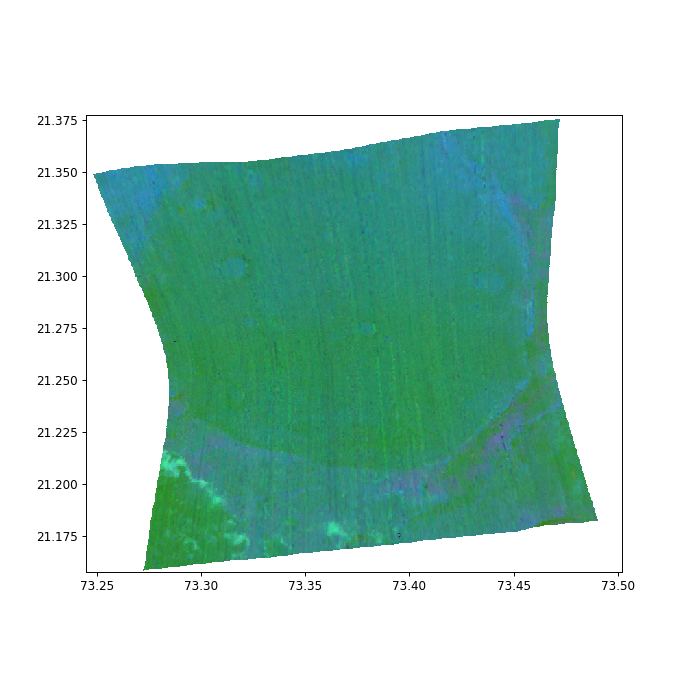

In [25]:
r = "BD1900_2"
#r = "R1320"
g = "MIN2200"
#g = "R1320"
#b="R1320"
b = "D2300"

# Note : Please take care that the coverage id has letters in lower case!
coverage_id = "frt0000c202_07_if165l_trr3"

url, encoded_url, point_clicked = URL_creator(coverage_id, r, g, b, summary_products)

## Spectral Analysis tool

* Uncomment the code below
* Click a point in the image
* Re-run the cell

In [26]:
#print(point_clicked)

#coordinate_lat = point_clicked["y"]
#coordinate_lon = point_clicked["x"]

#coordinates_xy = coordinates_trans(coordinate_lat, coordinate_lon, coverage_id)
#coordinate_x = coordinates_xy[1]
#coordinate_y = coordinates_xy[0]

#plot_spectra(coordinate_y, coordinate_x, coverage_id)